# Data Prep in Spark DataFrames using PySpark

## Import necessary packages

In [1]:
import pyspark

## Start SparkSession

In [2]:
spark = pyspark.sql.SparkSession \
    .builder \
    .master('local[*]') \
    .appName("Python Spark Consumer Complaints Data Prep Example") \
    .getOrCreate()

## Adjust Spark Settings to Show DataFrames more like Pandas DataFrames

In [32]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

## Import Data

In [3]:
df = spark.read.load('../data/consumer_complaints.parquet',
                     inferSchema="true", header="true")

## Check out DataFrame

In [228]:
df.describe()

summary,date_received,product,sub-product,issue,sub-issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided?,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response?,consumer_disputed?,complaint_id
count,1474568,1474568,1239403,1474568,919291,482567,550042,1474568,1450021,1337072,200924,865482,1474568,1474568,1474567,1474568,768480,1474568
mean,null,null,null,null,null,null,null,null,null,50860.12706557131,null,null,null,null,null,null,null,2115963.600992969
stddev,null,null,null,null,null,null,null,null,null,30898.337000119238,null,null,null,null,null,null,null,1020211.408555866
min,01/01/2012,Bank account or s...,(CD) Certificate ...,APR or interest rate,Account informati...,! ) forced placed...,Company believes ...,"(Former)Shapiro, ...",AA,(1352,Older American,Consent not provided,Email,01/01/2013,Closed,No,No,1
max,12/31/2019,Virtual currency,Virtual currency,Wrong amount char...,You told them to ...,• School Loan ser...,Company has respo...,Lippman Recupero...,WY,9`325,Servicemember,Other,Web,12/31/2019,Untimely response,Yes,Yes,3493133


In [44]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns])

date_received,product,sub-product,issue,sub-issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided?,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response?,consumer_disputed?,complaint_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [105]:
from pyspark.sql.functions import when, count, col

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
date_received,0
product,0
sub-product,235165
issue,0
sub-issue,555277
consumer_complaint_narrative,992001
company_public_response,924526
company,0
state,24547
zip_code,137496


### Are there duplicates? No

In [5]:
df.count()

1474568

In [6]:
df.distinct().count()

1474568

### Drop row with Null in "Company Response to Consumer"

In [63]:
df_clean = df.dropna(subset='company_response_to_consumer')

### Replace Null "Consumer Disputed?" With "No" and add a column to flag this change.

In [47]:
# check to see if desired value is 'No' or 'no'
df.select('consumer_disputed?')

consumer_disputed?
No
No
null
null
No
Yes
No
No
null
null


In [64]:
# add flag column
df_clean = df_clean.withColumn('null_c_disputed', df_clean['consumer_disputed?'].isNull())

In [65]:
# fill na in consumer_disputed? with 'No'
df_clean = df_clean.fillna('No', subset='consumer_disputed?')

In [58]:
# check results with the first 10 rows
df_clean.limit(10)

date_received,product,sub-product,issue,sub-issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided?,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response?,consumer_disputed?,complaint_id,null_c_disputed
08/09/2015,Credit reporting,null,Incorrect informa...,Information is no...,null,Company chooses n...,Experian Informat...,NJ,08872,null,Consent not provided,Web,08/09/2015,Closed with non-m...,Yes,No,1509954,false
02/06/2014,Mortgage,Other mortgage,Loan modification...,null,null,null,Ocwen Financial C...,CA,939XX,null,null,Referral,02/10/2014,Closed with expla...,Yes,No,700599,false
01/29/2019,"Credit reporting,...",Credit reporting,Problem with a cr...,Was not notified ...,null,null,"EQUIFAX, INC.",NY,10801,null,Consent not provided,Web,01/30/2019,Closed with non-m...,Yes,No,3136759,true
11/03/2019,"Credit reporting,...",Credit reporting,Problem with a cr...,Their investigati...,null,null,"EQUIFAX, INC.",SC,290XX,null,Consent not provided,Web,11/03/2019,Closed with expla...,Yes,No,3426837,true
08/19/2015,Mortgage,Conventional adju...,"Loan servicing, p...",null,null,Company chooses n...,WELLS FARGO & COM...,CA,94526,null,Consent not provided,Web,08/19/2015,Closed with expla...,Yes,No,1527601,false
03/04/2016,Credit card,null,Billing disputes,null,I am dissatisfied...,null,DISCOVER BANK,NV,891XX,null,Consent provided,Web,03/04/2016,Closed with expla...,Yes,Yes,1816726,false
03/18/2013,Mortgage,Other mortgage,Loan modification...,null,null,null,"BANK OF AMERICA, ...",PA,175XX,null,null,Referral,03/19/2013,Closed with expla...,Yes,No,358304,false
12/21/2011,Mortgage,Conventional fixe...,Loan modification...,null,null,null,"BANK OF AMERICA, ...",MD,210XX,null,null,Web,12/22/2011,Closed without re...,Yes,No,7362,false
10/24/2018,"Credit reporting,...",Credit reporting,Incorrect informa...,Account status in...,null,Company has respo...,SYNCHRONY FINANCIAL,CA,92595,Servicemember,Consent not provided,Web,10/24/2018,Closed with expla...,Yes,No,3054861,true
03/03/2018,"Credit reporting,...",Credit reporting,Incorrect informa...,Information belon...,On XX/XX/18 an it...,Company has respo...,TRANSUNION INTERM...,VA,245XX,null,Consent provided,Web,03/03/2018,Closed with expla...,Yes,No,2831821,true


### Add date-based columns: transit time (days between receipt and reporting to company), day of week

In [97]:
from pyspark.sql.functions import to_date, datediff, date_format, month

In [66]:
# add datetime columns
df_clean = df_clean.select('*', to_date(df_clean['date_received'], 'MM/dd/yyyy').alias('date_received_dt'))
df_clean = df_clean.select('*', to_date(df_clean['date_sent_to_company'], 'MM/dd/yyyy').alias('date_sent_to_company_dt'))

df_clean.dtypes

[('date_received', 'string'),
 ('product', 'string'),
 ('sub-product', 'string'),
 ('issue', 'string'),
 ('sub-issue', 'string'),
 ('consumer_complaint_narrative', 'string'),
 ('company_public_response', 'string'),
 ('company', 'string'),
 ('state', 'string'),
 ('zip_code', 'string'),
 ('tags', 'string'),
 ('consumer_consent_provided?', 'string'),
 ('submitted_via', 'string'),
 ('date_sent_to_company', 'string'),
 ('company_response_to_consumer', 'string'),
 ('timely_response?', 'string'),
 ('consumer_disputed?', 'string'),
 ('complaint_id', 'bigint'),
 ('null_c_disputed', 'boolean'),
 ('date_received_dt', 'date'),
 ('date_sent_to_company_dt', 'date')]

In [67]:
# drop string date columns
df_clean = df_clean.drop('date_received').drop('date_sent_to_company')

df_clean.dtypes

[('product', 'string'),
 ('sub-product', 'string'),
 ('issue', 'string'),
 ('sub-issue', 'string'),
 ('consumer_complaint_narrative', 'string'),
 ('company_public_response', 'string'),
 ('company', 'string'),
 ('state', 'string'),
 ('zip_code', 'string'),
 ('tags', 'string'),
 ('consumer_consent_provided?', 'string'),
 ('submitted_via', 'string'),
 ('company_response_to_consumer', 'string'),
 ('timely_response?', 'string'),
 ('consumer_disputed?', 'string'),
 ('complaint_id', 'bigint'),
 ('null_c_disputed', 'boolean'),
 ('date_received_dt', 'date'),
 ('date_sent_to_company_dt', 'date')]

In [74]:
# add time difference between receipt and sent to company
df_clean = df_clean.withColumn('transit_time', 
                    datediff(df_clean['date_sent_to_company_dt'], 
                             df_clean['date_received_dt']))

In [76]:
# add submitted day of week (1=Monday, 7=Sunday)
df_clean = df_clean.withColumn('dow_submitted', date_format('date_received_dt', 'u').alias('dow_submitted'))

In [98]:
# add submitted month, year

df_clean = df_clean.withColumn('y_submitted', date_format('date_received_dt', 'y').alias('y_submitted')) \
                    .withColumn('m_submitted', month('date_received_dt').alias('m_submitted'))

In [99]:
df_clean.take(5)

[Row(product='Credit reporting', sub-product=None, issue='Incorrect information on credit report', sub-issue='Information is not mine', consumer_complaint_narrative=None, company_public_response='Company chooses not to provide a public response', company='Experian Information Solutions Inc.', state='NJ', zip_code='08872', tags=None, consumer_consent_provided?='Consent not provided', submitted_via='Web', company_response_to_consumer='Closed with non-monetary relief', timely_response?='Yes', consumer_disputed?='No', complaint_id=1509954, null_c_disputed=False, date_received_dt=datetime.date(2015, 8, 9), date_sent_to_company_dt=datetime.date(2015, 8, 9), transit_time=0, dow_submitted='7', y_submitted='2015', m_submitted=8),
 Row(product='Mortgage', sub-product='Other mortgage', issue='Loan modification,collection,foreclosure', sub-issue=None, consumer_complaint_narrative=None, company_public_response=None, company='Ocwen Financial Corporation', state='CA', zip_code='939XX', tags=None, con

In [100]:
df_clean.limit(5)

# note: here it seems like limit takes longer (maybe processing the whole table?) than take,
# but the output is not cute.

product,sub-product,issue,sub-issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided?,submitted_via,company_response_to_consumer,timely_response?,consumer_disputed?,complaint_id,null_c_disputed,date_received_dt,date_sent_to_company_dt,transit_time,dow_submitted,y_submitted,m_submitted
Credit reporting,null,Incorrect informa...,Information is no...,null,Company chooses n...,Experian Informat...,NJ,08872,null,Consent not provided,Web,Closed with non-m...,Yes,No,1509954,false,2015-08-09,2015-08-09,0,7,2015,8
Mortgage,Other mortgage,Loan modification...,null,null,null,Ocwen Financial C...,CA,939XX,null,null,Referral,Closed with expla...,Yes,No,700599,false,2014-02-06,2014-02-10,4,4,2014,2
"Credit reporting,...",Credit reporting,Problem with a cr...,Was not notified ...,null,null,"EQUIFAX, INC.",NY,10801,null,Consent not provided,Web,Closed with non-m...,Yes,No,3136759,true,2019-01-29,2019-01-30,1,2,2019,1
"Credit reporting,...",Credit reporting,Problem with a cr...,Their investigati...,null,null,"EQUIFAX, INC.",SC,290XX,null,Consent not provided,Web,Closed with expla...,Yes,No,3426837,true,2019-11-03,2019-11-03,0,7,2019,11
Mortgage,Conventional adju...,"Loan servicing, p...",null,null,Company chooses n...,WELLS FARGO & COM...,CA,94526,null,Consent not provided,Web,Closed with expla...,Yes,No,1527601,false,2015-08-19,2015-08-19,0,3,2015,8


### Check States

Data courtesy of [SimpleMaps](https://simplemaps.com/data/us-zips) CC4.0

In [104]:
zips_df = pd.read_csv('../data/uszips.csv')
zips_df.head().T

,0,1,2,3,4
zip,601,602,603,606,610
lat,18.18,18.3607,18.4544,18.1672,18.2903
lng,-66.7522,-67.1752,-67.122,-66.9383,-67.1224
city,Adjuntas,Aguada,Aguadilla,Maricao,Anasco
state_id,PR,PR,PR,PR,PR
state_name,Puerto Rico,Puerto Rico,Puerto Rico,Puerto Rico,Puerto Rico
zcta,True,True,True,True,True
parent_zcta,NaN,NaN,NaN,NaN,NaN
population,17242,38442,48814,6437,27073
density,111.4,523.5,667.9,60.4,312


In [112]:
states = list(zips_df['state_id'].unique())

In [117]:
# add clean state column, drop original column, rename new column
df_clean = df_clean.withColumn('state_c', when(col('state').isin(states), col('state')).otherwise('unknown')) \
                    .drop('state').withColumnRenamed('state_c', 'state')

In [232]:
df_clean.filter(df_clean['state'] == 'unknown').count()

26225

## Now that my data is prepped, I'm ready to check out the data

In [124]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

### How does the number of complaints received relate to the day of the week?

In [123]:
dow = df_clean.groupby("dow_submitted").count().orderBy('dow_submitted').toPandas()

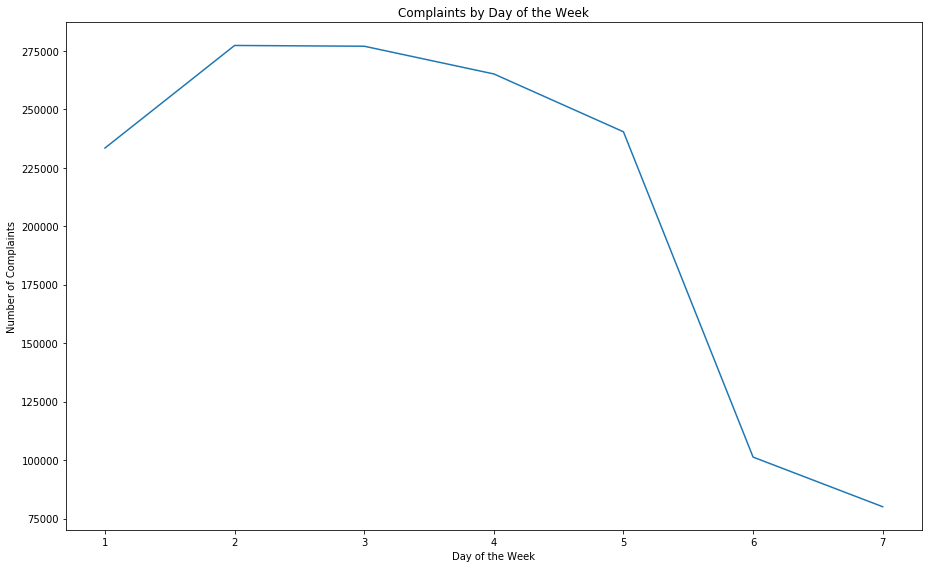

In [128]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(dow['dow_submitted'], dow['count'])
ax.set_title("Complaints by Day of the Week")
ax.set_xlabel("Day of the Week")
ax.set_ylabel('Number of Complaints')

plt.savefig('images/dow.png')

### How has the number of complaints changed over time (by year)?

In [129]:
year = df_clean.groupby("y_submitted").count().orderBy('y_submitted').toPandas()

In [144]:
# data for 2011 and 2020 are only partial years. So I decided to cut them
year = year[1:9]

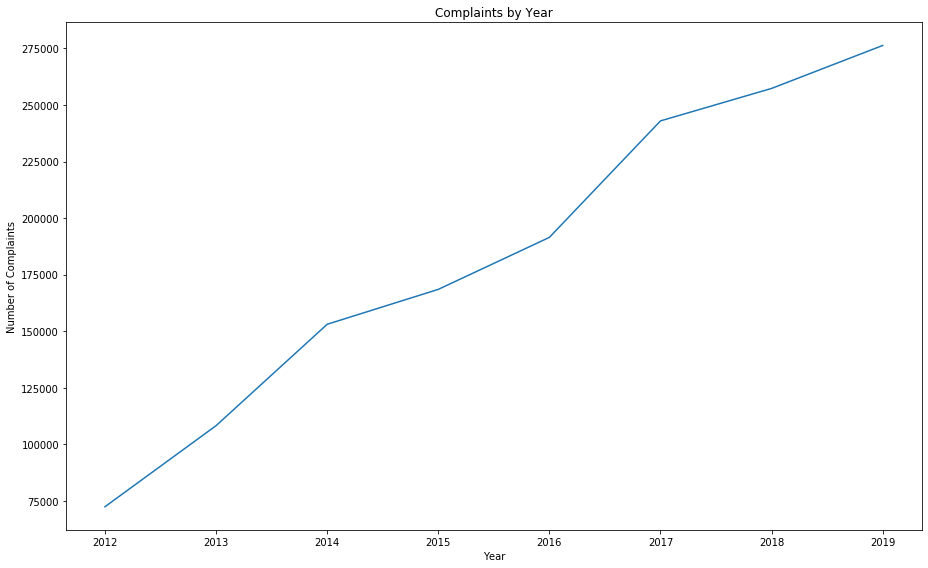

In [143]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(year['y_submitted'], year['count'])
ax.set_title("Complaints by Year")
ax.set_xlabel("Year")
ax.set_ylabel('Number of Complaints')

plt.savefig('images/year.png')

### How has the number of complaints changed over time (by month)?

In [148]:
month = df_clean.groupby("y_submitted", "m_submitted").count().orderBy("y_submitted", "m_submitted").toPandas()

In [160]:
month['m_submitted'] = month['m_submitted'].astype(str)
month['y_submitted'] = month['y_submitted'].astype(str)
month['period'] = month[['m_submitted', 'y_submitted']].apply(lambda x: ' '.join(x), axis=1)
month

,y_submitted,m_submitted,count,period
0,2011,12,2536,12 2011
1,2012,1,3230,1 2012
2,2012,2,3509,2 2012
3,2012,3,6230,3 2012
4,2012,4,5703,4 2012
...,...,...,...,...
93,2019,9,23578,9 2019
94,2019,10,25636,10 2019
95,2019,11,22686,11 2019
96,2019,12,20570,12 2019


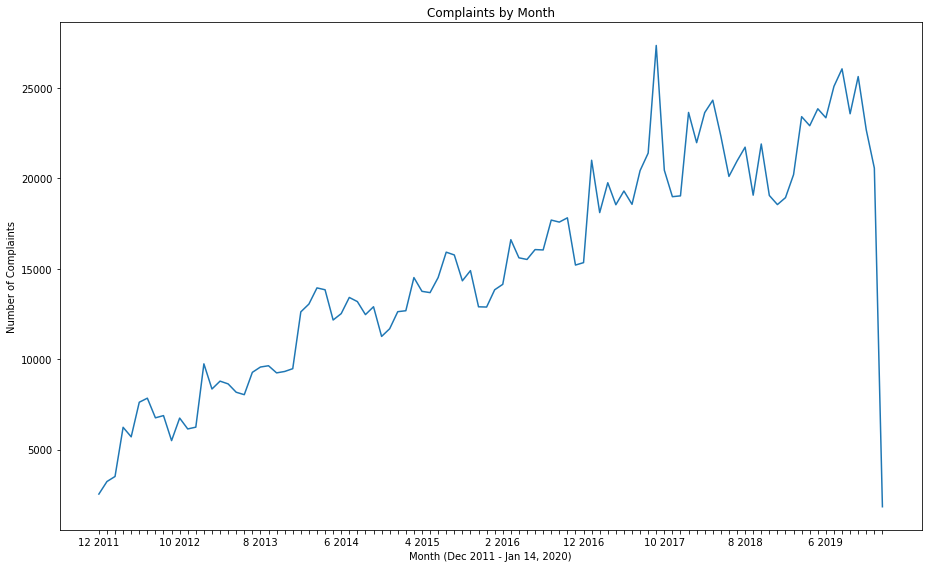

In [164]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(month['period'], month['count'])
ax.set_title("Complaints by Month")
ax.set_xlabel("Month (Dec 2011 - Jan 14, 2020)")
ax.set_ylabel('Number of Complaints')

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.savefig('images/month.png')

### Count of Complaints in Each State --> Map relative # of complaints as compared to state population

See state_complaint_visualizations.ipynb for mapping

In [165]:
state_counts = df_clean.groupby("state").count().toPandas()

In [172]:
state_pops = zips_df[['state_id', 'population']].groupby(['state_id']).sum()
state_pops = state_pops.reset_index()
state_pops.columns = ['state', 'population']

In [177]:
state_counts.dtypes

state    object
count     int64
dtype: object

In [179]:
state_info = state_counts.set_index('state').join(state_pops.set_index('state'))

In [180]:
state_info.to_csv('../data/complaints_per_state.csv')

### Top 20 Products

In [224]:
prods = df_clean.groupby('product').count().orderBy('count', ascending=False).toPandas()

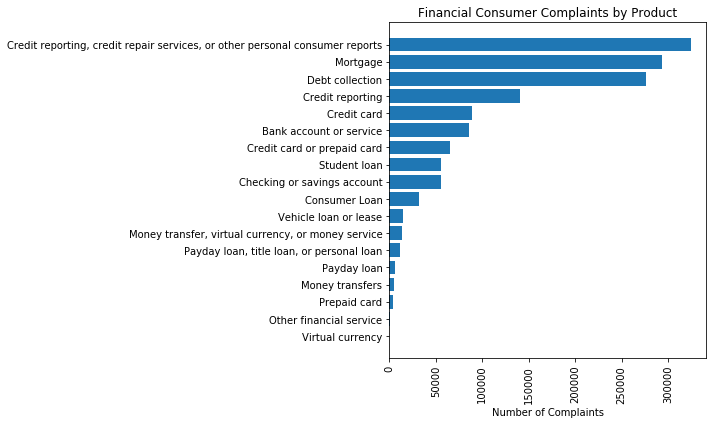

In [226]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(y=prods['product'], 
       width=prods['count'])
ax.set_title("Financial Consumer Complaints by Product")
ax.set_xlabel("Number of Complaints")
plt.xticks(rotation=90)
ax.invert_yaxis()

plt.savefig('images/products.png')

In [219]:
prods = prods.sort_values('count', ascending=False)

In [218]:
prods

,product,count
1,Virtual currency,18
15,Other financial service,1059
7,Prepaid card,3819
3,Money transfers,5354
2,Payday loan,5543
17,"Payday loan, title loan, or personal loan",11644
4,"Money transfer, virtual currency, or money ser...",13792
14,Vehicle loan or lease,15088
10,Consumer Loan,31604
5,Checking or savings account,55682
